### 🖋️ Phishing Detection in Email Bodies

In this notebook, we will build a **classification model** for the **Phishing detection on the email body** task using ML algorithmns such as `Logistic Regression` and `Random Forest Classifier`.  
The goal is to predict the phishing of a given email body.  

The dataset that we are using will be loaded from google drive and which was previously processed in the previous notebook.


---

### ⚙️ Installing Helper Packages

In the following code cell, we will install the packages `helperfns`, `kaggle`, and `pigmenta`.  
These libraries provide useful utilities for machine learning workflows, including data preprocessing, visualization, and experiment management.

**References:**

1. [helperfns on PyPI](https://pypi.org/project/helperfns/)  
2. [pigmenta on PyPI](https://pypi.org/project/pigmenta/)


In [1]:
!pip install helperfns pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 38.9 MB/s eta 0:00:00


In the following code cell, we will import all the essential Python libraries required for this notebook. These libraries will be used for data preprocessing, visualization, feature extraction, and building the `Logistic Regression` and `Random Forest Classifier`.


In [31]:
import random
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn

from pigmenta import PALETTES
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from google.colab import drive
from helperfns.tables import tabulate_data

warnings.filterwarnings('ignore')
print("Pandas: ", pd.__version__)
print("Seaborn: ", sns.__version__)
print("Sklearn: ", sklearn.__version__)
print("Numpy: ", np.__version__)

Pandas:  2.2.2
Seaborn:  0.13.2
Sklearn:  1.6.1
Numpy:  2.0.2


### Seed  

In the following code cell, we will set a fixed random seed to ensure **reproducibility** of all random operations in this notebook. This guarantees that results remain consistent across multiple runs.


In [3]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)

### Mounting Google Drive
In the following code cell we are going to mount the google drive where our dataset will be loaded that was previously cleaned in the previous notebook.

In [5]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


### 📂 Dataset

Next, we will read our data from text files into a **Pandas DataFrame** using the `read_csv` method.  
We will load only the `clean_phishing_email.csv` file, as it contains the email body samples along with their corresponding **labels**.

**Objective:** Accurately identify the phishing emails based on the email body.

In [6]:
dataframe = pd.read_csv("/content/MyDrive/MyDrive/NLP Data/zim/clean_phishing_email.csv")
dataframe.head(2)

,body,label
0,buck up your troubles caused by small dimensio...,phishing
1,upgrade your sex and pleasures with these tech...,phishing


In the following code cell, we will **check the size of the dataset**.

In [7]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 98,260


In the following code cell we are going to remove `nan` values from the dataset if there are any.

In [8]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()
dataframe.head(2)

,body,label
0,buck up your troubles caused by small dimensio...,phishing
1,upgrade your sex and pleasures with these tech...,phishing


In the following code cell, we are going to define a threshold value and filter out all text entries that contain fewer words than this threshold. We want to make sure that short emails are removed.

In [9]:
threshold = 100
dataframe = dataframe[dataframe['body'].apply(lambda x: len(str(x).split()) >= threshold)].reset_index(drop=True)
dataframe.head(2)

,body,label
0,the daily top from cnn com top videos and stor...,phishing
1,would anyone object to removing so from this l...,legitimate


Next, we are going to inspect a few examples from the dataset after removing all rows containing text with fewer words than the defined threshold.

In [11]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 51,487


In this section, we will **visualize the dataset** using charts.  
First, we will examine the **distribution of labels** with a bar chart to understand how the text samples are distributed across different labels.

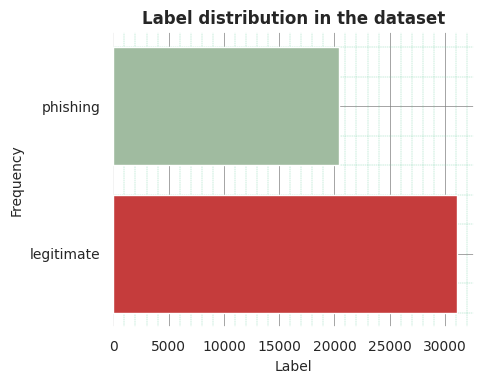

In [12]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(5, 4))
sns.countplot(data=dataframe, y="label", palette=PALETTES.christmas,
              legend=False,  fill=True)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(f"Label distribution in the dataset", fontsize=12, weight="bold")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Handling Class Imbalance

The dataset is **not balanced**, meaning some labels classes have significantly more examples than others.  
To ensure that **accuracy** remains a reliable performance metric, we will **downsample the majority classes** so that each labels class has approximately the same number of samples as the minority class `(Ngwenya and Garidzira, 2025)`.  

This approach helps prevent the model from becoming biased toward the majority classes and allows for a more fair evaluation of model performance.

> Ngwenya, S. and Garidzira, T.C., 2025. Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation. The Indonesian Journal of Computer Science, 14(4).


In [13]:
new_dataframe = dataframe.copy()

min_class_count = new_dataframe['label'].value_counts().min()
downsampled_list = []
for label in new_dataframe['label'].unique():
    class_df = new_dataframe[new_dataframe['label'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

### 🍰 Visualizing the Balanced Dataset

In the following code cell, we are going to **visualize the distribution** of the balanced dataset using a **pie chart**.  
This visualization helps us confirm that all label classes now have approximately equal representation after the downsampling process.

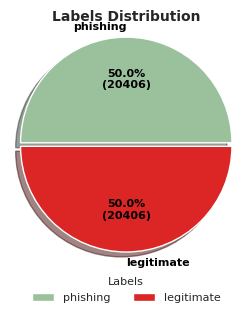

In [14]:
samples = dict(balanced_df.label.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.christmas,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Labels Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Labels", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In [17]:
print(f"The size of the balanced dataset is: {len(balanced_df):,}")

The size of the balanced dataset is: 40,812


In the following code cell, we will **split the dataset into two subsets**: a **training set** for model training and a **test set** for evaluating model performance.


In [18]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)

In the following code cell, we will examine the **distribution of each label** in the dataset. This allows us to verify the balance between best `legitimate` and `phishing` before training the models.


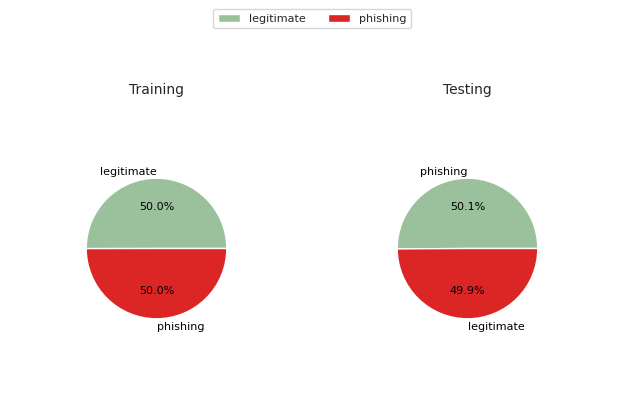

In [21]:

train_dist_label	= {i:0 for i in train.label.unique()}
for val in train.label:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.label.unique()}
for val in test.label:
  test_dist_label[val] += 1

fig, axes = plt.subplots(1, 2)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=.6,
            colors= PALETTES.christmas
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=.6,
            colors= PALETTES.christmas
            )
axes[1].set_title("Testing", fontsize=10)


fig.legend(train.label.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In the following code cell, we will **extract the features and labels** from the dataset. Additionally, we will **clean the book descriptions** by removing unwanted characters and formatting, preparing the text data for model training.


In [22]:
train_texts = train.body.values
train_labels = train.label.values

test_texts = test.body.values
test_labels = test.label.values

### Most commmon words

In the following code cell we are going to use the `Counter` object to check create a word to count mapping of words in the training and testing dataset.

In [24]:
test_counter = Counter()
train_counter = Counter()

for line in train_texts:
    train_counter.update(line.lower().split())

for line in test_texts:
    test_counter.update(line.lower().split())

In the next code cell we are going to visualize the most common words in the training and testing subset.

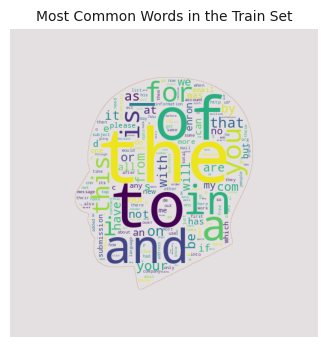

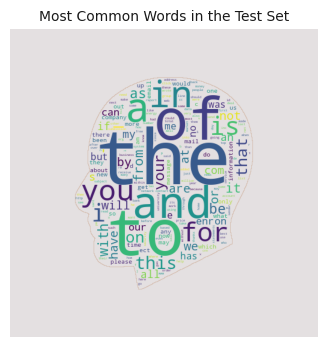

In [25]:
plot_wordcloud(
    train_counter, title="Most Common Words in the Train Set", mask="head", figsize=(4, 4),
    fontsize=10
)
plot_wordcloud(
    test_counter, title="Most Common Words in the Test Set", mask="head", figsize=(4, 4),
    fontsize=10
)

The most appearing words in the training and testing subset for email body are `stopword`. According to `Sarica and  Luo (2024)`,  stopwords are words that carries less semantic meaning on their own  for example words like "the", "of", "to", etc. and we are going to remove these words during text preprocessing.

> S. Sarica and J. Luo, “Correction: Stopwords in technical language processing,” PLoS One, vol. 19, no. 12, p. e0315195, Dec. 2024, doi: 10.1371/journal.pone.0315195.



Our labels are categorical, so we want to convert them to numbers. For that we are going to use the `LabelEncoder` to encode our labels to become `numerical`.

In [27]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels.reshape(-1, 1))
y_test = label_encoder.transform(test_labels.reshape(-1, 1))

In the following code cell we are going to check a sample of encoded labels.

In [28]:
y_train[:2], y_test[:2]

(array([0, 1]), array([1, 0]))

In the following code cell, we will create **pipelines for the model** as a list, pairing **`LogisticRegression`** and **`RandomForestClassifier`** with different vectorizers — **`CountVectorizer`**, **`HashingVectorizer`**, and **`TfidfVectorizer`**.


This will allow us to **compare their performance** and determine the most effective feature representation for predicting phishing from email bodies.



> **Note:** We are filtering out stopword to be `english` in the vectorizers.


In [ ]:
scores_data = []

vectorizers = [
    ("CountVectorizer", CountVectorizer(stop_words='english')),
    ("TfidfVectorizer", TfidfVectorizer(stop_words='english')),
    ("HashingVectorizer", HashingVectorizer(alternate_sign=False, stop_words='english'))
]

classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=100)),
    ("Random Forest Classifier", RandomForestClassifier(n_estimators=100))
]

for vec_name, vect in vectorizers:
    for clf_name, clf in classifiers:
        pipe = Pipeline([
            ("vect", vect),
            ("clf", clf)
        ])
        pipe.fit(train_texts, y_train)
        score = pipe.score(test_texts, y_test)
        scores_data.append({"vectorizer": vec_name, "classifier": clf_name, "score": score})
        print(f"{vec_name} + {clf_name}: {score:.4f}")
    print()

In [34]:
scores_df = pd.DataFrame(scores_data)
scores_df.head(10)

,vectorizer,classifier,score
0,CountVectorizer,Logistic Regression,0.990567
1,CountVectorizer,Random Forest Classifier,0.986157
2,TfidfVectorizer,Logistic Regression,0.984687
3,TfidfVectorizer,Random Forest Classifier,0.987505
4,HashingVectorizer,Logistic Regression,0.981134
5,HashingVectorizer,Random Forest Classifier,0.985667


In the following code cell, we will **visualize the performance of each vectorizer** with **corresponding classifier** by plotting their corresponding **accuracy scores**.

This helps us compare which feature representation works best for predicting phishing from email bodies.


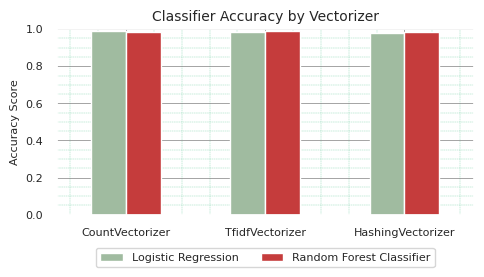

In [33]:
plt.figure(figsize=(5, 3))
sns.barplot(data=scores_df, x="vectorizer",
            y="score", hue="classifier",
            palette=PALETTES.christmas, width= .5
            )

plt.title("Classifier Accuracy by Vectorizer", fontsize=10)
plt.ylabel("Accuracy Score", fontdict={'fontsize': 8})
plt.xlabel("", fontdict={'fontsize': 8})
plt.ylim(0, 1.0)
plt.legend(fontsize=8,  loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

In the following code cell, we will create two classifiers—**Random Forest** and **Logistic Regression**—each paired with suitable vectorizers. Our goal is to determine which combination produces the best performance for predicting phishing in email body text.


> We will then conduct further evaluations on the best-performing model.

In [40]:
lr_pipe = Pipeline([
    ("vect",  CountVectorizer(stop_words='english')),
    ("clf", LogisticRegression(max_iter=100))
])
rf_pipe = Pipeline([
    ("vect",  TfidfVectorizer(stop_words='english')),
    ("clf", RandomForestClassifier(n_estimators=100))
])

lr_pipe.fit(train_texts, y_train)
rf_pipe.fit(train_texts, y_train)


Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier())])

In the following code cell, we will tabulate the performance metrics of the best-selected model combination, including **accuracy**, **F1-score**, **precision**, and **recall**, based on the testing dataset.



In [45]:
y_preds_lr = lr_pipe.predict(test_texts)
y_preds_rf = rf_pipe.predict(test_texts)
rows = [
    ["LR", f"{accuracy_score(y_test, y_preds_lr)*100:.2f}", f"{f1_score(y_test, y_preds_lr):.3f}", f"{precision_score(y_test, y_preds_lr):.3f}", f"{recall_score(y_test, y_preds_lr):.3f}"],
    ["RF", f"{accuracy_score(y_test, y_preds_rf)*100:.2f}", f"{f1_score(y_test, y_preds_rf):.3f}", f"{precision_score(y_test, y_preds_rf):.3f}", f"{recall_score(y_test, y_preds_rf):.3f}"]
]
tabulate_data(["PIPELINE", "ACCURACY", "F1-SCORE", "PRECISION", 'RECALL'], rows, "BEST MODELS' EVALUATION METRICS")

BEST MODELS' EVALUATION METRICS
+----------+----------+----------+-----------+--------+
| PIPELINE | ACCURACY | F1-SCORE | PRECISION | RECALL |
+----------+----------+----------+-----------+--------+
| LR       |    99.06 |    0.991 |     0.989 |  0.992 |
| RF       |    98.69 |    0.987 |     0.994 |  0.980 |
+----------+----------+----------+-----------+--------+


### 🧮 Confusion Matrix

In the following code cell, we will **plot the confusion matrix** for our models.  


This visualization helps us understand how well the model predicts each phishing label and where misclassifications occur.


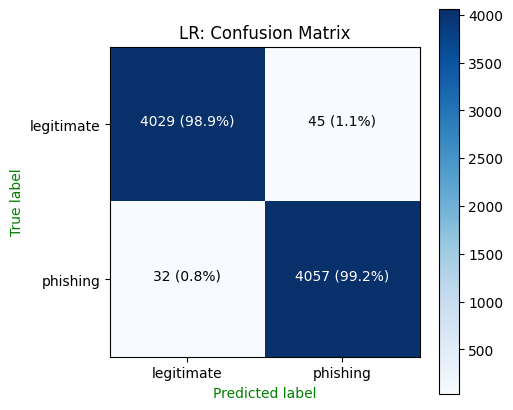

In [47]:
plt.style.use('default')
plot_complicated_confusion_matrix(y_test, y_preds_lr,
  label_encoder.classes_, fontsize=10, figsize=(5, 5), title="LR: Confusion Matrix"
)

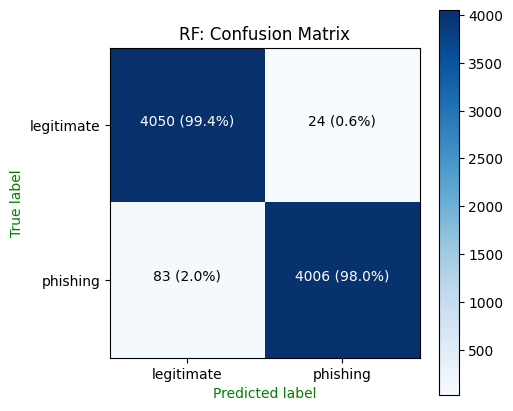

In [48]:
plot_complicated_confusion_matrix(y_test, y_preds_rf,
  label_encoder.classes_, fontsize=10, figsize=(5, 5), title="RF: Confusion Matrix"
)

### 📋 Classification Report

Next, we will **generate and display the classification report** for our model using the test dataset.  
This report provides metrics such as **precision, recall, F1-score, and support** for each class.


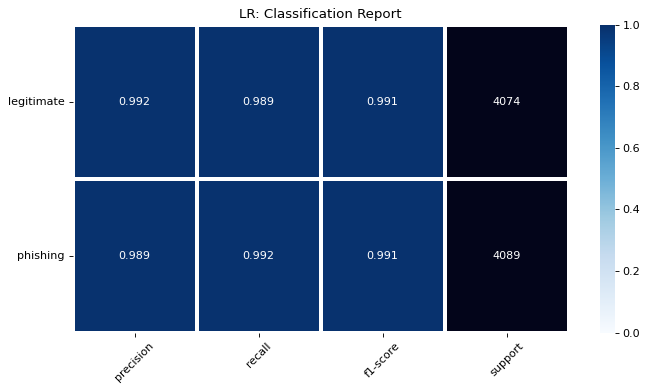

In [49]:
fig, ax = plot_classification_report(
    y_test, y_preds_lr,
    title='LR: Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = label_encoder.classes_
)

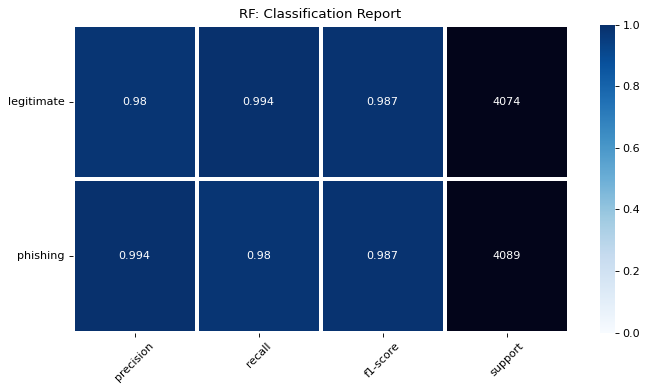

In [50]:
fig, ax = plot_classification_report(
    y_test, y_preds_rf,
    title='RF: Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = label_encoder.classes_
)

### 🤖 Model Inference

In this section, we will **test our model's ability to make predictions** based on user input.  

In the following code cell, we will use the **best model pipelines** to generate predictions.


In [51]:
MENTION_HASHTAG_RE = re.compile(r"(@|#)([A-Za-z0-9]+)")
EMAIL_RE = re.compile(r"([A-Za-z0-9]+[._-])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Za-z]{2,})+")
URL_RE = re.compile(r"https?\S+", re.MULTILINE)
DIGIT_RE = re.compile(r"\d")
PUNCT_RE = re.compile(r"[^\w\s\']")
SPACE_RE = re.compile(r"\s+")

def clean_sentence(sent: str, lower: bool = True) -> str:
    if lower:
        sent = sent.lower()
    sent = MENTION_HASHTAG_RE.sub(" ", sent)
    sent = EMAIL_RE.sub(" ", sent)
    sent = URL_RE.sub(" ", sent)
    sent = DIGIT_RE.sub(" ", sent)
    sent = PUNCT_RE.sub(" ", sent)
    sent = SPACE_RE.sub(" ", sent).strip()
    return sent

In [52]:
def predict_phishing(body, pipeline):
  body = clean_sentence(body)
  prediction = pipeline.predict([body])
  return { "prediction": int(prediction[0]),
          "label": label_encoder.inverse_transform(prediction)[0]}

### 📝 Prediction Example

In the following code cell, we will **predict a sample input**.



In [53]:
test.head(2)

,body,label
5499,dear computer user your internet usage is bein...,phishing
23254,sciencenow week in review all free articles to...,legitimate


### `Phishing`

In [54]:
phishing_txt = "dear computer user your internet usage is being tracked you have no privacy protection will your boss wife or kids find out download ez internet privacy software you're in serious trouble it's a proven fact deleting internet cache and history will not protect you because any of the web pages pictures movies videos sounds e mail chat logs and everything else you see or do could easily be recovered to haunt you forever how would you feel if a snoop made this information public to your spouse mother father neighbors children boss or the media it could easily ruin your life solve all your problems and enjoy all the benefits of an as new pc ez internet privacy software can speed up your pc internet browser reclaim hard disk space and professionally clean your pc in one easy mouse click did you know for example that every click you make on windows start menu is logged and stored permanently on a hidden encrypted database within your own computer deleting internet cache and history will not protect you your pc is keeping frightening records of both your online and off line activity any of the web pages pictures movies videos sounds e mail and everything else you or anyone else have ever viewed could easily be recovered even many years later how would you feel if somebody snooped this information out of your computer and made it public do your children or their friends use your computers what have they downloaded and tried to delete act now and stop these files coming back from the dead to haunt you click here to be removed click here iys"

print("Using LR:\n")
predict_phishing(
    phishing_txt, lr_pipe
)

Using LR:



{'prediction': 1, 'label': 'phishing'}

In [55]:
print("Using RF:\n")
predict_phishing(
    phishing_txt, rf_pipe
)

Using RF:



{'prediction': 1, 'label': 'phishing'}

### `Legitimate`

In [56]:
legitimate_txt = "sciencenow week in review all free articles top last month scienceshots daily news archive about sciencenow all these sciencenow stories and more are available at www sciencenow org monday february navigating uncertain seasnew study says researchers lack data to determine whether global warming is redirecting ocean currents i hear you my monkey brothera region of the monkey brain responds preferentially to the voices of other monkeys unsubscribe or edit your subscriptions for this service at written requests to unsubscribe may be sent to customer service page mill road palo alto ca u s a magazine news signaling careers multimedia collections help site map rss subscribe feedback privacy legal about us advertise with us contact us american association for the advancement of science all rights reserved aaas is a partner of hinari agora patientinform crossref and counter"

print("Using LR:\n")
predict_phishing(
    legitimate_txt, lr_pipe
)


Using LR:



{'prediction': 0, 'label': 'legitimate'}

In [57]:
print("Using RF:\n")
predict_phishing(
    legitimate_txt, rf_pipe
)

Using RF:



{'prediction': 0, 'label': 'legitimate'}